In [1]:
# Install importów

!pip install pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
# Wczytanie danych

route_segments = pd.read_csv('data/route_segments.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
orders_products = pd.read_csv('data/orders_products.csv')

# Usunięcie wierszy z brakującymi danymi

route_segments.dropna(inplace=True)
orders.dropna(inplace=True)
products.dropna(inplace=True)
orders_products.dropna(inplace=True)

# Filtrowanie segmentów dostaw

stop_segments = route_segments[route_segments['segment_type'] == 'STOP'].copy()
stop_segments['delivery_duration_sec'] = (
    pd.to_datetime(stop_segments['segment_end_time']) - pd.to_datetime(stop_segments['segment_start_time'])
).dt.total_seconds()

# Usunięcie nieprawidłowych wartości

stop_segments = stop_segments[stop_segments['delivery_duration_sec'] > 0]

# Zaokrąglenie w górę do minut

stop_segments['delivery_duration_min'] = stop_segments['delivery_duration_sec'].apply(lambda x: math.ceil(x / 60))

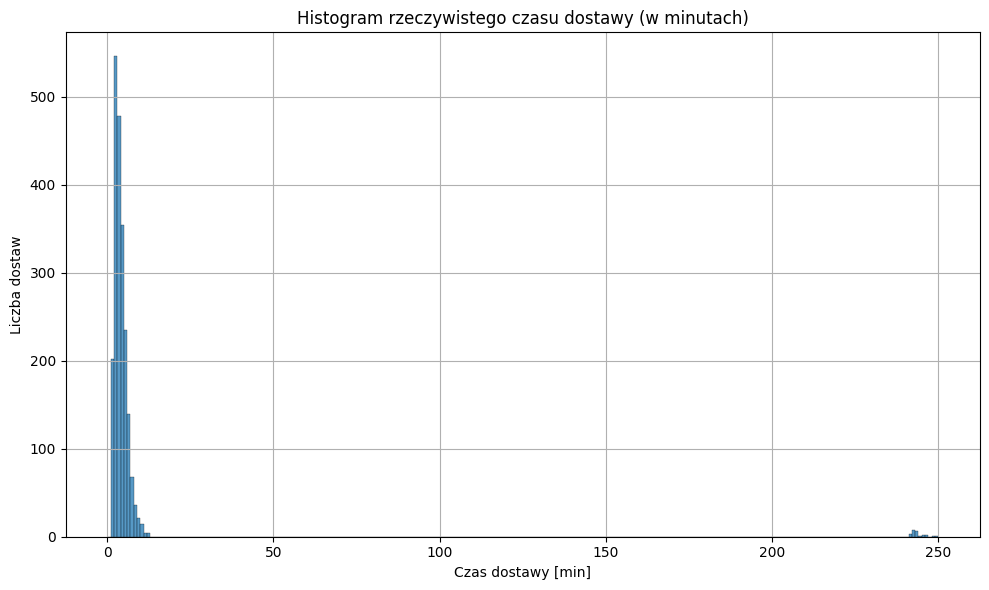

In [4]:
# Part 2_1 (Rzeczywisty czas dostawy w min zaokrąglony w górę)

plt.figure(figsize=(10,6))
sns.histplot(stop_segments['delivery_duration_min'], bins=range(0, stop_segments['delivery_duration_min'].max()+1), kde=False)
plt.title("Histogram rzeczywistego czasu dostawy (w minutach)")
plt.xlabel("Czas dostawy [min]")
plt.ylabel("Liczba dostaw")
plt.grid(True)
plt.tight_layout()
plt.savefig("raports/results/1_histogram_delivery_duration.png")

In [5]:
# Połączenie z orders

merged = stop_segments.merge(orders[['order_id', 'sector_id', 'planned_delivery_duration']], on='order_id')
merged = merged.dropna(subset=['planned_delivery_duration', 'sector_id'])

# Obliczanie błędu predykcji

merged['prediction_error_sec'] = merged['delivery_duration_sec'] - merged['planned_delivery_duration']

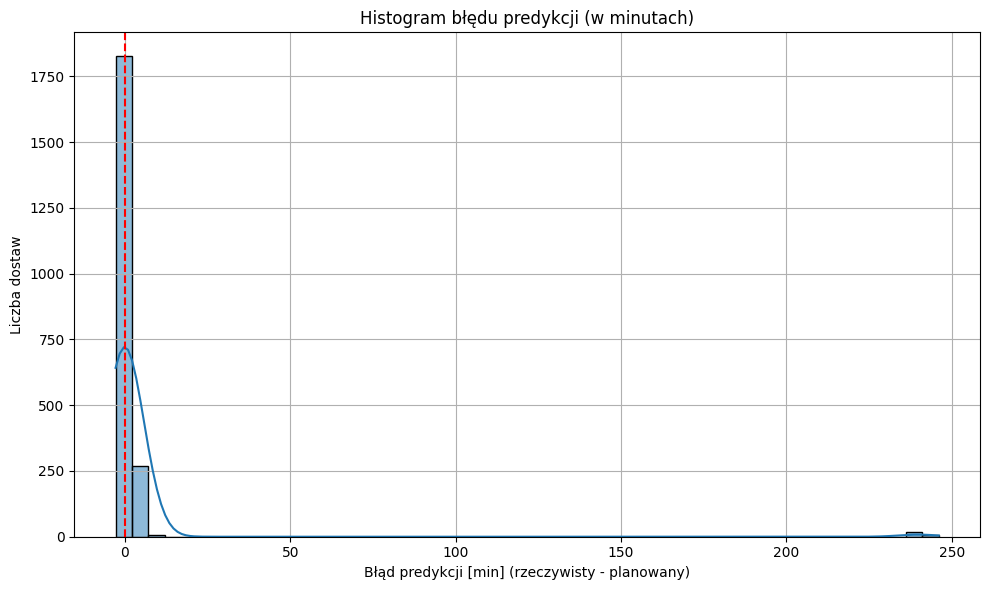

In [6]:
# Part 2_2 (Błąd predykcji)

plt.figure(figsize=(10,6))
sns.histplot(merged['prediction_error_sec'] / 60, bins=50, kde=True)
plt.title("Histogram błędu predykcji (w minutach)")
plt.xlabel("Błąd predykcji [min] (rzeczywisty - planowany)")
plt.ylabel("Liczba dostaw")
plt.axvline(0, color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.savefig("raports/results/2_prediction_error_histogram.png")

In [7]:
# Obliczanie czasu dostaw dla sektorów

sector_stats = merged.groupby('sector_id')['delivery_duration_min'].mean().reset_index()

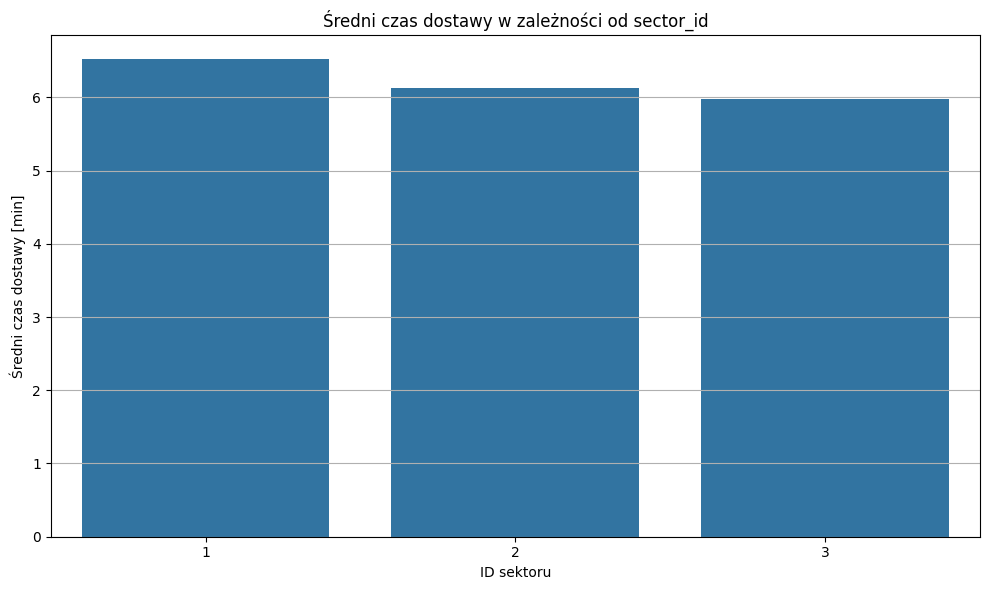

In [8]:
# Part 2_3 (Uśredniony czas dostaw dla sektorów)

plt.figure(figsize=(10,6))
sns.barplot(x='sector_id', y='delivery_duration_min', data=sector_stats)
plt.title("Średni czas dostawy w zależności od sector_id")
plt.xlabel("ID sektoru")
plt.ylabel("Średni czas dostawy [min]")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("raports/results/3_sector_duration.png")

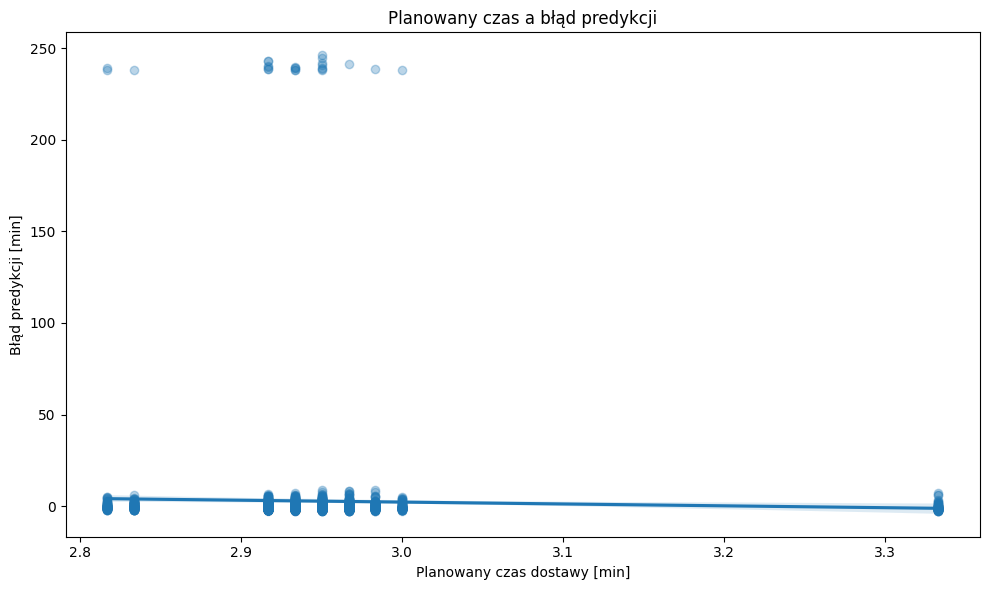

In [9]:
# Part 2_4_1 (Planowany czas a błąd predykcji)

plt.figure(figsize=(10,6))
sns.regplot(data=merged, x=merged['planned_delivery_duration']/60, y=merged['prediction_error_sec']/60, scatter_kws={'alpha':0.3})
plt.title('Planowany czas a błąd predykcji')
plt.xlabel('Planowany czas dostawy [min]')
plt.ylabel('Błąd predykcji [min]')
plt.tight_layout()
plt.savefig("raports/results/4_1_planned_vs_error_regression.png")

In [10]:
# Obliczanie wagi zamówienia

orders_products = orders_products.merge(products, on='product_id')
orders_products['total_weight'] = orders_products['weight'] * orders_products['quantity']
order_weights = orders_products.groupby('order_id')['total_weight'].sum().reset_index()

# Połączenie wag z czasem dostawy

analysis = merged.merge(order_weights, on='order_id')

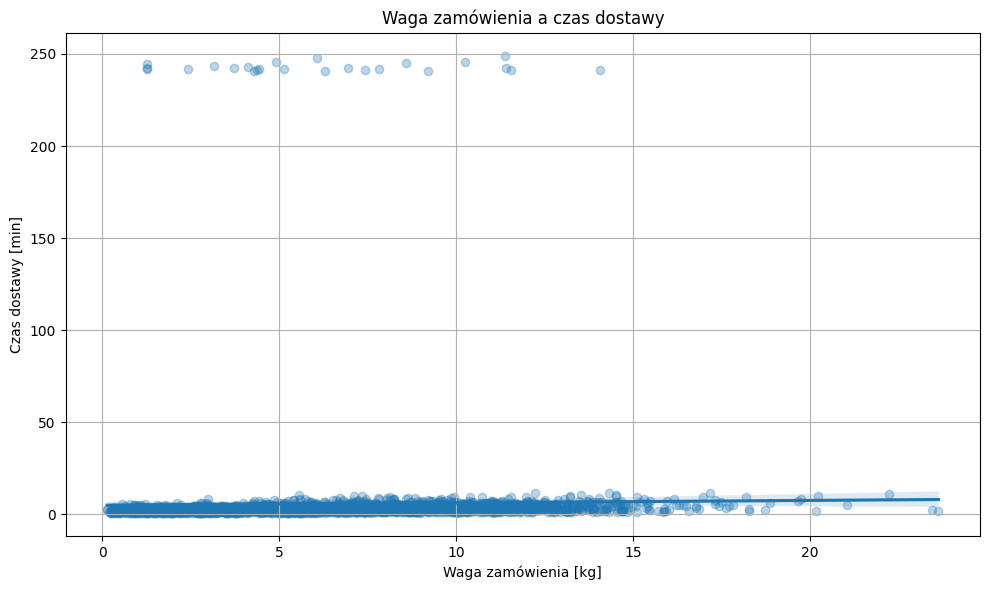

In [11]:
# Part 2_4_2 (Waga zamówienia a rzeczywisty czas dostawy)

plt.figure(figsize=(10,6))
sns.regplot(data=analysis, x=analysis['total_weight']/1000, y=analysis['delivery_duration_sec']/60, scatter_kws={'alpha':0.3})
plt.title("Waga zamówienia a czas dostawy")
plt.xlabel("Waga zamówienia [kg]")
plt.ylabel("Czas dostawy [min]")
plt.grid(True)
plt.tight_layout()
plt.savefig("raports/results/4_2_weight_vs_delivery.png")

In [12]:
# Liczba produktów w zamówieniu

order_size = orders_products.groupby('order_id')['quantity'].sum().reset_index(name='total_quantity')

# Połączenie z czasem dostawy

order_size_analysis = merged.merge(order_size, on='order_id')

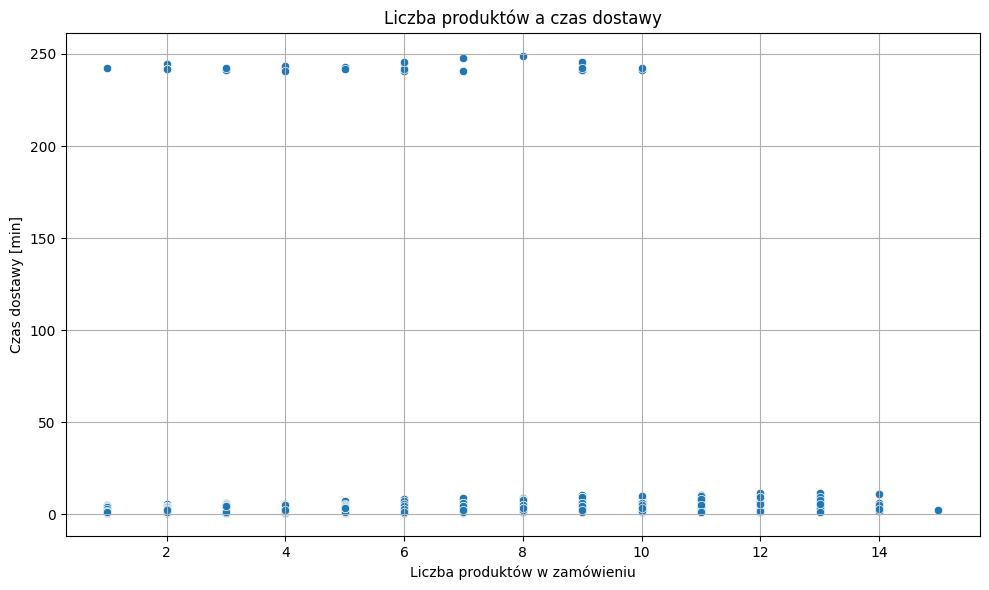

In [13]:
# Part 2_4_3 (Liczba produktów w zamówieniu a czas dostawy)

plt.figure(figsize=(10,6))
sns.scatterplot(x=order_size_analysis['total_quantity'], y=order_size_analysis['delivery_duration_sec']/60)
plt.title("Liczba produktów a czas dostawy")
plt.xlabel("Liczba produktów w zamówieniu")
plt.ylabel("Czas dostawy [min]")
plt.grid(True)
plt.tight_layout()
plt.savefig("raports/results/4_3_quantity_vs_delivery.png")

In [14]:
# Ekstrakcja godziny

merged['hour'] = pd.to_datetime(merged['segment_end_time']).dt.hour

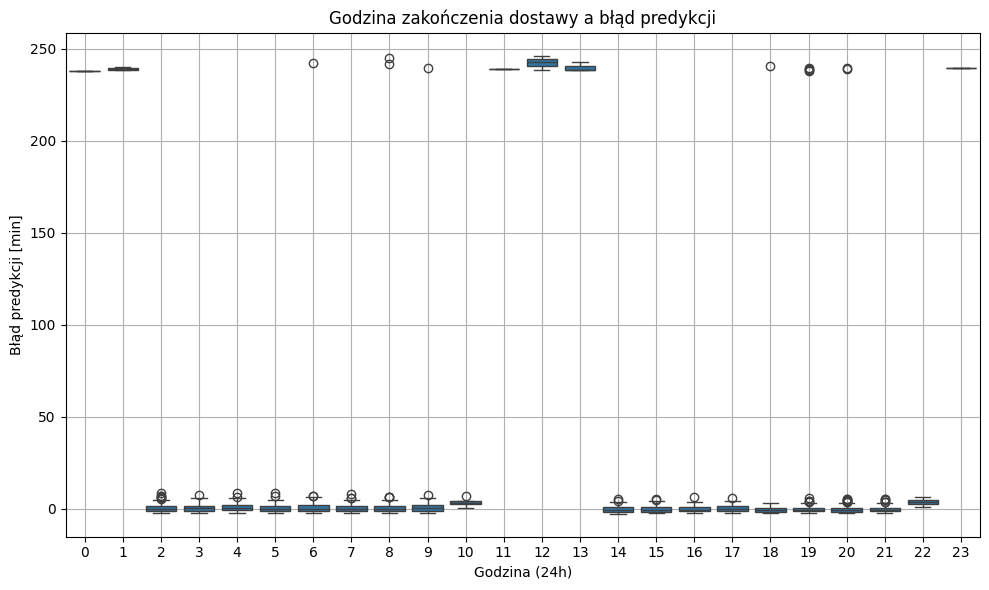

In [15]:
# Part 2_4_4 (Godzina dostawy a błąd predykcji)

plt.figure(figsize=(10,6))
sns.boxplot(x=merged['hour'], y=merged['prediction_error_sec'] / 60)
plt.title("Godzina zakończenia dostawy a błąd predykcji")
plt.xlabel("Godzina (24h)")
plt.ylabel("Błąd predykcji [min]")
plt.grid(True)
plt.tight_layout()
plt.savefig("raports/results/4_4_hour_vs_prediction_error.png")

In [16]:
# Przygotowanie dni tygodnia

merged['weekday'] = pd.to_datetime(merged['segment_end_time']).dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

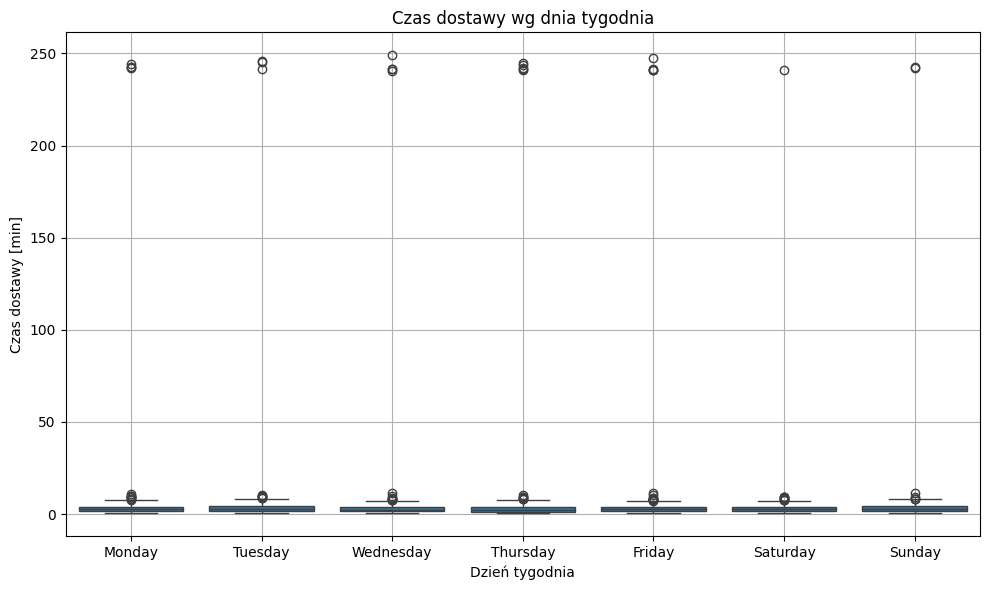

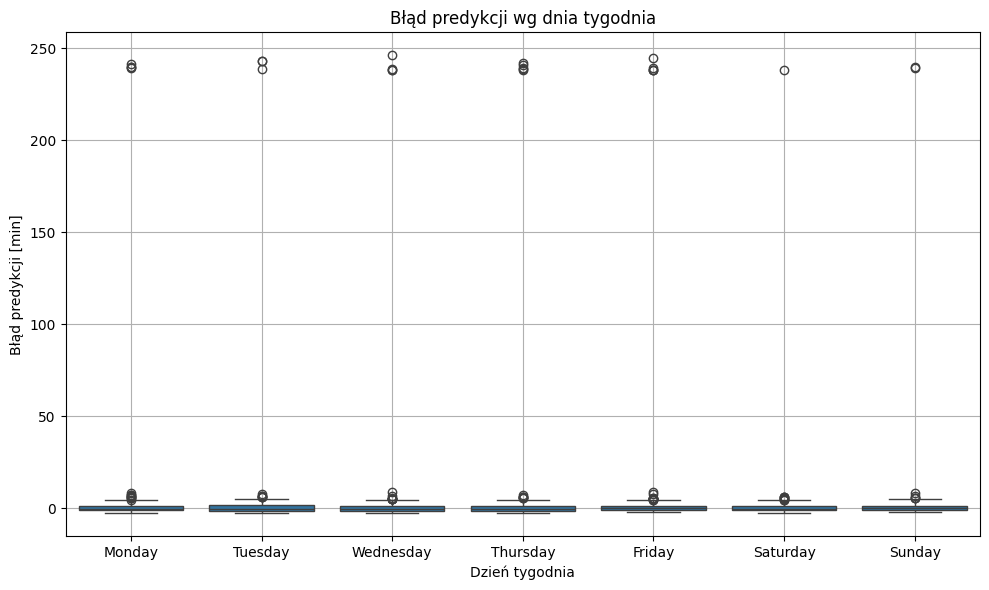

In [17]:
# Part 2_4_5 (Czas dostawy i błąd a dzień tygodnia)

plt.figure(figsize=(10,6))
sns.boxplot(data=merged, x='weekday', y=merged['delivery_duration_sec']/60, order=weekday_order)
plt.title('Czas dostawy wg dnia tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('Czas dostawy [min]')
plt.grid(True)
plt.tight_layout()
plt.savefig("raports/results/4_5_1_delivery_vs_weekday.png")

plt.figure(figsize=(10,6))
sns.boxplot(data=merged, x='weekday', y=merged['prediction_error_sec']/60, order=weekday_order)
plt.title('Błąd predykcji wg dnia tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('Błąd predykcji [min]')
plt.grid(True)
plt.tight_layout()
plt.savefig("raports/results/4_5_2_prediction_error_vs_weekday.png")

In [18]:
# Informacje o kierowcach

merged = merged.drop(columns=['driver_id'], errors='ignore')
driver_delivery = merged.merge(route_segments[['segment_id', 'driver_id']], on='segment_id')

driver_stats = driver_delivery.groupby('driver_id')['delivery_duration_sec'].mean().reset_index()

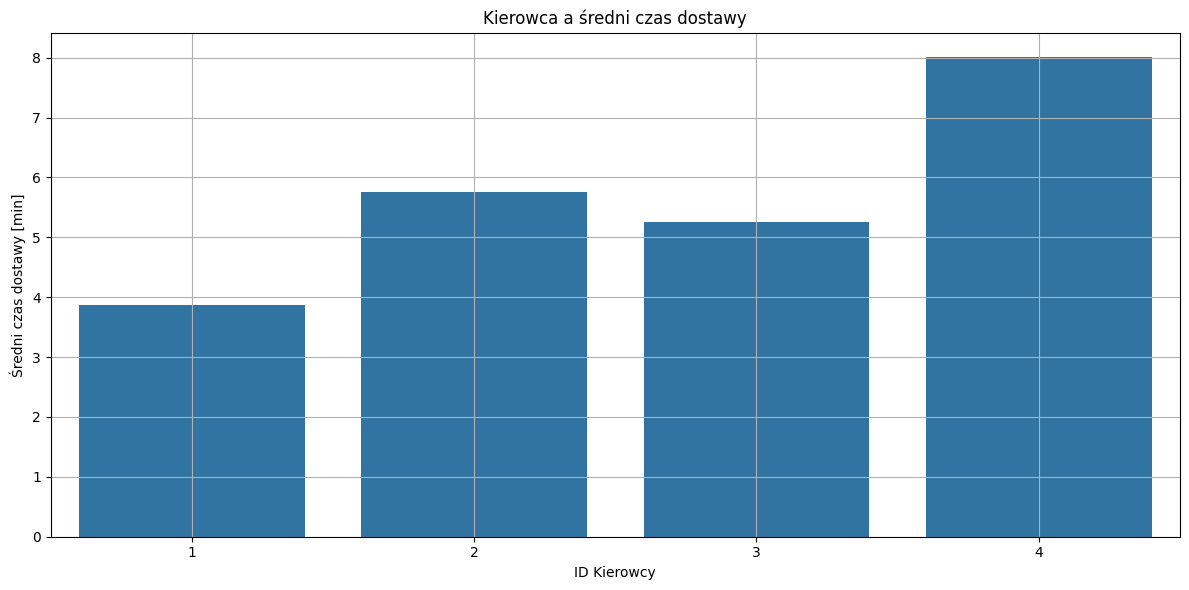

In [19]:
# Part 2_4_6 (Kierowca a rzeczywisty czas dostawy)

plt.figure(figsize=(12,6))
sns.barplot(data=driver_stats, x='driver_id', y=driver_stats['delivery_duration_sec'] / 60)
plt.title("Kierowca a średni czas dostawy")
plt.xlabel("ID Kierowcy")
plt.ylabel("Średni czas dostawy [min]")
plt.grid(True)
plt.tight_layout()
plt.savefig("raports/results/4_6_driver_vs_delivery_time.png")

In [20]:
# Podział wielkości zamówienia

order_size_analysis['quantity_bin'] = pd.cut(order_size_analysis['total_quantity'], bins=[0, 1, 3, 5, 10, 20, np.inf], labels=['1', '2-3', '4-5', '6-10', '11-20', '21+'])

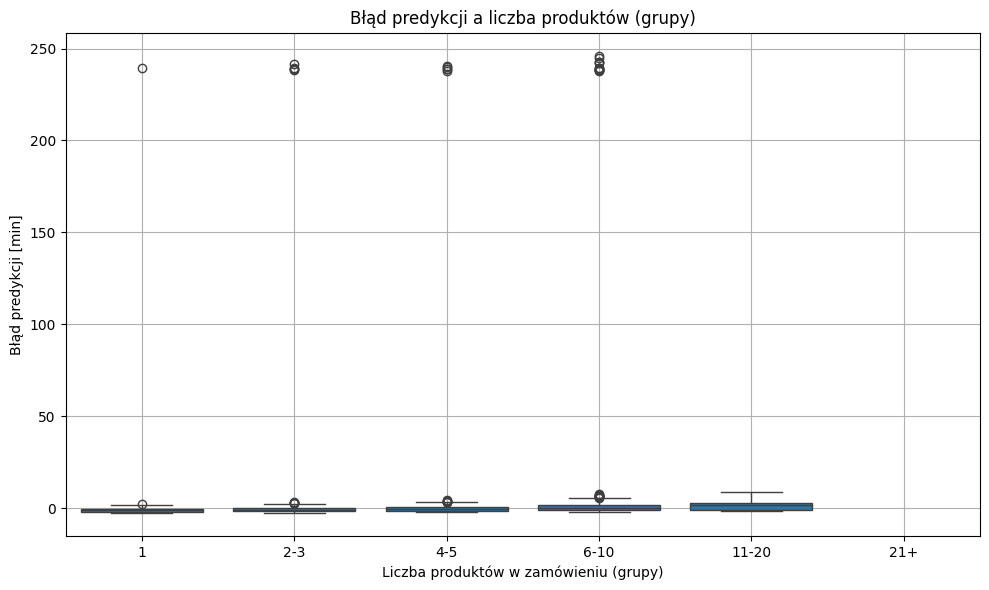

In [21]:
# Part 2_4_7 (Rozkład błędu predykcji w zależności od wielkości zamówienia)

plt.figure(figsize=(10,6))
sns.boxplot(data=order_size_analysis, x='quantity_bin', y=order_size_analysis['prediction_error_sec'] / 60)
plt.title("Błąd predykcji a liczba produktów (grupy)")
plt.xlabel("Liczba produktów w zamówieniu (grupy)")
plt.ylabel("Błąd predykcji [min]")
plt.grid(True)
plt.tight_layout()
plt.savefig("raports/results/4_7_error_vs_product_count_bins.png")

In [22]:
# Łączenie wag i liczby produktów

full_analysis = analysis.merge(order_size, on='order_id')

# Korelacje

full_analysis['prediction_error_sec'] = full_analysis['delivery_duration_sec'] - full_analysis['planned_delivery_duration']
corr_cols = ['total_weight', 'delivery_duration_sec', 'planned_delivery_duration', 'prediction_error_sec', 'total_quantity']
corr_matrix = full_analysis[corr_cols].corr()

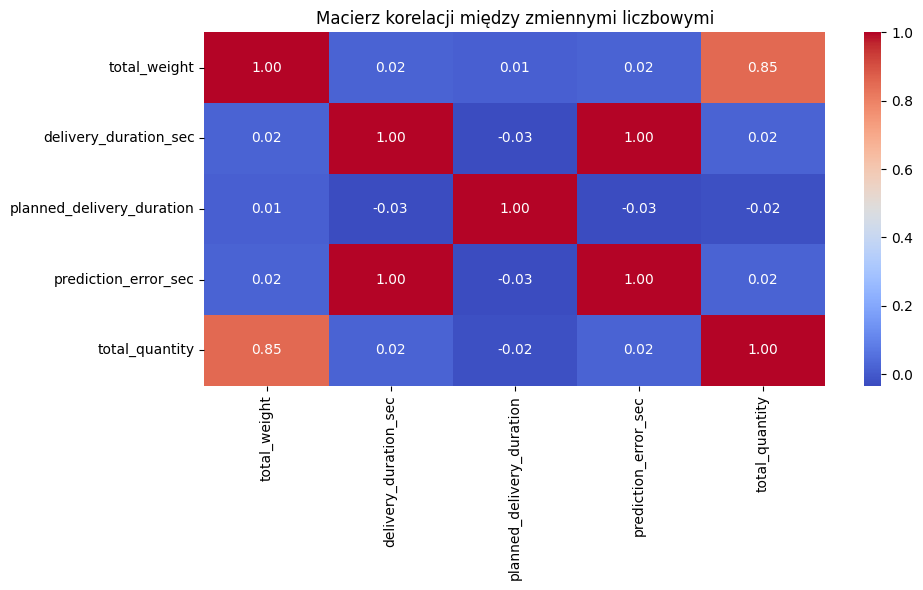

In [23]:
# Part 2_4_8 (Macierz Korelacji)

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Macierz korelacji między zmiennymi liczbowymi')
plt.tight_layout()
plt.savefig("raports/results/4_8_correlation_matrix.png")

In [24]:
# Prób błędu do analizy 100 minut = 6000

threshold_error_sec = 100 * 60

# Filtrowanie zamówień z wysokim błędem predykcji

high_error_df = merged[merged['prediction_error_sec'] > threshold_error_sec].copy()

# Dodanie kolumny błędu oraz kalsycznego czasu dostawy wyrażonego w minutach

high_error_df['prediction_error_min'] = high_error_df['prediction_error_sec'] / 60

high_error_df['planned_duration_min'] = high_error_df['planned_delivery_duration'] / 60

# Przygotowanie tabeli przeglądowej z najważniejszymi zmiennymi

high_error_overview = high_error_df[['order_id', 'sector_id', 'delivery_duration_sec', 'delivery_duration_min', 'planned_delivery_duration', 'planned_duration_min', 'prediction_error_sec', 'prediction_error_min', 'hour', 'weekday']]

# Ilość rekordów o dużej ilości błędu
high_error_overview_length = high_error_df.shape[0]

# Grupowanie rekordów z wysokim błędem wg sector_id
high_error_by_sector = high_error_df.groupby('sector_id').agg(
    count=('order_id', 'nunique'),
    mean_planned_duration_sec=('planned_delivery_duration', 'mean'),
    mean_planned_duration_min=('planned_duration_min', 'mean'),
    mean_delivery_duration_sec=('delivery_duration_sec', 'mean'),
    mean_delivery_duration_min=('delivery_duration_min', 'mean'),
    mean_error_sec=('prediction_error_sec', 'mean'),
    mean_error_min=('prediction_error_min', 'mean')
).reset_index()

# Grupowanie rekordów z wysokim błędem wg dnia tygodnia
high_error_by_weekday = high_error_df.groupby('weekday').agg(
    count=('order_id', 'nunique'),
    mean_planned_duration_sec=('planned_delivery_duration', 'mean'),
    mean_planned_duration_min=('planned_duration_min', 'mean'),
    mean_delivery_duration_sec=('delivery_duration_sec', 'mean'),
    mean_delivery_duration_min=('delivery_duration_min', 'mean'),
    mean_error_sec=('prediction_error_sec', 'mean'),
    mean_error_min=('prediction_error_min', 'mean')
).reset_index()

# Grupowanie rekordów z wysokim błędem wg godziny dostawy
high_error_by_hour = high_error_df.groupby('hour').agg(
    count=('order_id', 'nunique'),
    mean_planned_duration_sec=('planned_delivery_duration', 'mean'),
    mean_planned_duration_min=('planned_duration_min', 'mean'),
    mean_delivery_duration_sec=('delivery_duration_sec', 'mean'),
    mean_delivery_duration_min=('delivery_duration_min', 'mean'),
    mean_error_sec=('prediction_error_sec', 'mean'),
    mean_error_min=('prediction_error_min', 'mean')
).reset_index()

In [25]:
# Printy wizuzalizacyjne korelację danych o dużym współczynniku błędu

print(f"Liczba zamówień z błędem powyżej 100 minut: {high_error_overview_length}")

print("\nTabela zamówień z błędem predykcji powyżej 100 minut:")
print(high_error_overview.head(high_error_overview_length))

print("\nPodsumowanie zamówień z dużym błędem predykcji według sector_id:")
print(high_error_by_sector)

print("\nPodsumowanie zamówień z dużym błędem predykcji według dnia tygodnia:")
print(high_error_by_weekday)

print("\nPodsumowanie zamówień z dużym błędem predykcji według godziny:")
print(high_error_by_hour)

Liczba zamówień z błędem powyżej 100 minut: 24

Tabela zamówień z błędem predykcji powyżej 100 minut:
      order_id  sector_id  delivery_duration_sec  delivery_duration_min  \
168      461.0          2                14501.0                    242   
275      636.0          1                14859.0                    248   
394      734.0          2                14692.0                    245   
441      149.0          3                14459.0                    241   
492     1020.0          2                14573.0                    243   
752        7.0          3                14747.0                    246   
754      941.0          1                14671.0                    245   
813     1606.0          3                14497.0                    242   
818     1356.0          1                14523.0                    243   
835     1182.0          2                14538.0                    243   
932     1500.0          3                14496.0                    242  

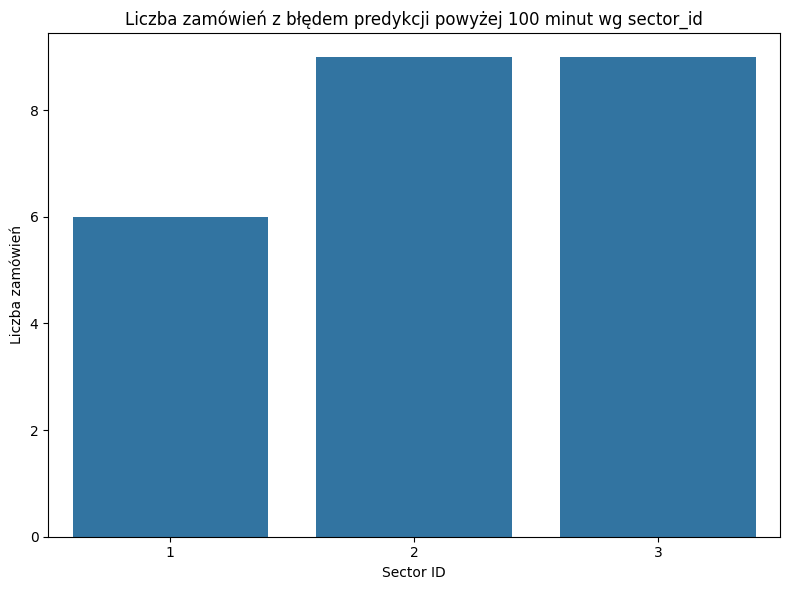

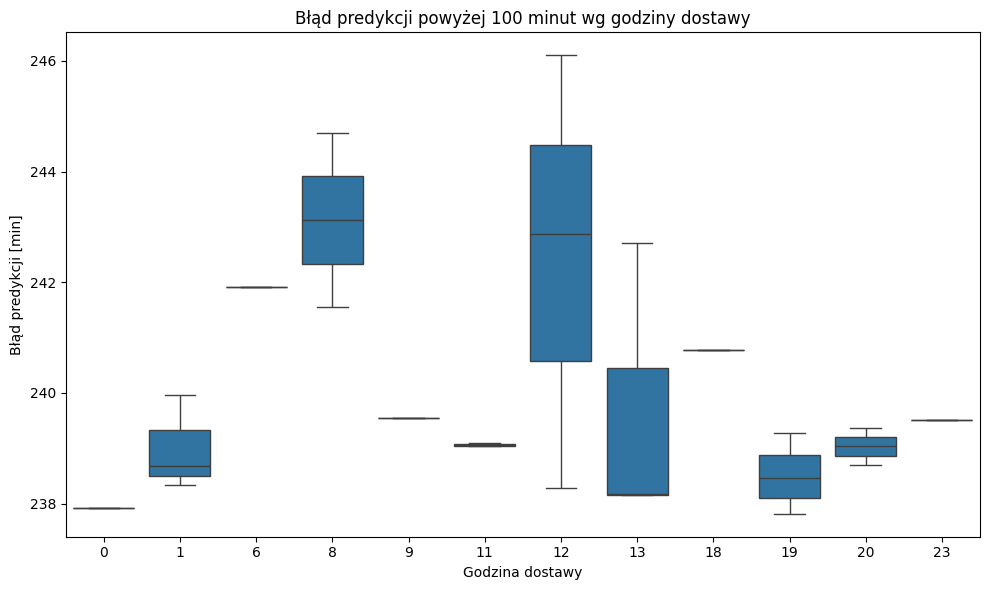

In [26]:
# Wykresy wizuzalizacyjne korelację danych o dużym współczynniku błędu

plt.figure(figsize=(8,6))
sns.countplot(data=high_error_df, x='sector_id')
plt.title("Liczba zamówień z błędem predykcji powyżej 100 minut wg sector_id")
plt.xlabel("Sector ID")
plt.ylabel("Liczba zamówień")
plt.tight_layout()
plt.savefig("raports/results/high_error_orders_by_sector.png")

plt.figure(figsize=(10,6))
sns.boxplot(data=high_error_df, x='hour', y='prediction_error_min')
plt.title("Błąd predykcji powyżej 100 minut wg godziny dostawy")
plt.xlabel("Godzina dostawy")
plt.ylabel("Błąd predykcji [min]")
plt.tight_layout()
plt.savefig("raports/results/high_error_orders_by_hour.png")